**MNIST with CNN** 


---

1. drive/My Drive/public/data/ has data
2. drive/My Drive/public/results/ will have results


* make sure you have images in drive/My Drive/public/data/mnist_test_images/


Mount your good drive. Check by '! ls' command

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!ls

drive  sample_data


Import PyTorch library and check by printing the version information 

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 

from torchvision import datasets, transforms
import numpy as np

import warnings
warnings.filterwarnings('ignore')
import os

In [4]:
print(torch.__version__)

1.9.0+cu102


Define your network model. We have defined simple CNN model in advance. 

In [5]:
class MNIST_CNN_model(nn.Module):
    def __init__(self):
        super(MNIST_CNN_model, self).__init__()
        self.conv = nn.Sequential(
            # conv layer 1
            nn.Conv2d(1, 20, 5, 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            # conv layer 2
            nn.Conv2d(20, 50, 5, 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )
        
        conv_size = self.get_conv_size((1, 28, 28)) # tensor of a MNIST image
        
        self.fc = nn.Sequential(
            nn.Linear(conv_size, 500), # conv_size = 4*4*50
            nn.Linear(500, 10)
        )
    
    def get_conv_size(self, shape):
        o = self.conv(torch.zeros(1, *shape))
        return int(np.prod(o.size()))

    def forward(self, x):
        batch_size, c, h, w = x.data.size() # 32*1*28*28
        x = self.conv(x)
        x = x.view(batch_size, -1) # conv_size = 4*4*50
        x = self.fc(x)
        return F.log_softmax(x, dim=1)


In [6]:
model = MNIST_CNN_model()
print(model)

MNIST_CNN_model(
  (conv): Sequential(
    (0): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=800, out_features=500, bias=True)
    (1): Linear(in_features=500, out_features=10, bias=True)
  )
)


Load MNIST datset 

In [7]:
batch_size = 32
test_batch_size = 1000
kwargs = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}

transform=transforms.Compose([
   transforms.ToTensor(),
   transforms.Normalize((0.1307,), (0.3081,)) ])

train_dataset = datasets.MNIST('drive/My Drive/public/data', train=True, 
    download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset,
    batch_size=batch_size, shuffle=True, **kwargs)

test_dataset = datasets.MNIST('drive/My Drive/public/data', train=False, 
                   transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset,
    batch_size=test_batch_size, shuffle=True, **kwargs)

In [8]:
for batch, (data, target) in enumerate(train_loader):
  print('data shape: ', data.shape)
  print('target shape: ', target.shape)
  break

data shape:  torch.Size([32, 1, 28, 28])
target shape:  torch.Size([32])


In [9]:
def train(model, device, train_loader, optimizer, epoch, log_interval):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            
            # sum up batch loss
            test_loss += F.nll_loss(output, target, reduction='sum').item()  

            # get the index of the max log-probability
            pred = output.argmax(dim=1, keepdim=True)                        
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

Define hyper-parameters for training. Then define model and optimizer


In [10]:
seed = 1
epochs = 1
lr = 0.001
momentum = 0.9
log_interval = 100
save_model = True

torch.manual_seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

Train the model by running training loop

In [11]:
for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, epoch, log_interval)
    test(model, device, test_loader)

if (save_model):
    if not os.path.exists('drive/My Drive/public/results'):
        os.mkdir('drive/My Drive/public/results')
    torch.save(model,"drive/My Drive/public/results/mnist_cnn.pth")

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.270011
Train Epoch: 1 [3200/60000 (5%)]	Loss: 1.122234
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.344270
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.315768
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.089297
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.461053
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.198120
Train Epoch: 1 [22400/60000 (37%)]	Loss: 0.335903
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.342060
Train Epoch: 1 [28800/60000 (48%)]	Loss: 0.138001
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.080668
Train Epoch: 1 [35200/60000 (59%)]	Loss: 0.077281
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.192091
Train Epoch: 1 [41600/60000 (69%)]	Loss: 0.044424
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.030723
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.011970
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.076489
Train Epoch: 1 [54400/60000 (91%)]	Loss: 0.125510
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.067922

Test: Average loss: 0.0949, Accuracy: 9702/10000 (97%)



In [16]:
!ls "drive/My Drive/public/results"

mnist_cnn.pth  mnist_nn.pth


After Training
* load the trained model
* test with one image or with one directory

In [13]:
load_model = torch.load("drive/My Drive/public/results/mnist_cnn.pth")

Model prediction:  7


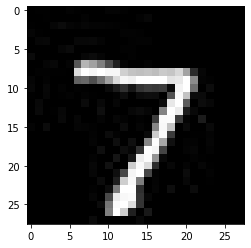

In [19]:
from skimage import io
import matplotlib.pyplot as plt

img_name = 'drive/My Drive/public/data/mnist_test_images/test_0.jpg'
test_img = io.imread(img_name).reshape(28,28)
test_data = transform(test_img).view(1,1,28,28).to(device)
fig = plt.figure
plt.imshow(test_img, cmap='gray')
with torch.no_grad():
  output=load_model(test_data)
print('Model prediction: ', output.argmax(dim=1).cpu().numpy()[0])
plt.show()
print(' ')

Model prediction:  4


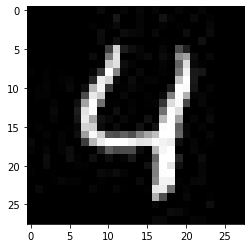

 
Model prediction:  5


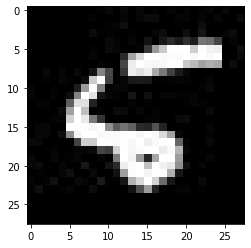

 
Model prediction:  1


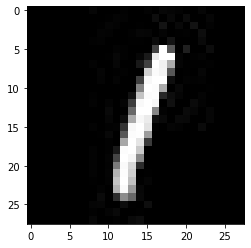

 
Model prediction:  9


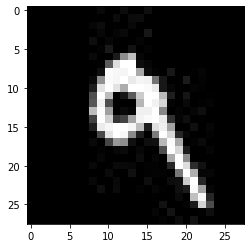

 
Model prediction:  0


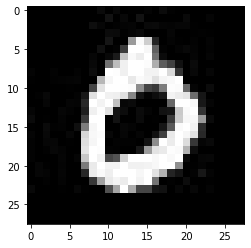

 
Model prediction:  4


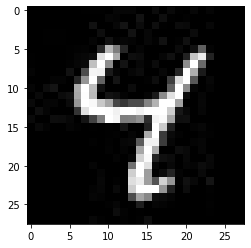

 
Model prediction:  1


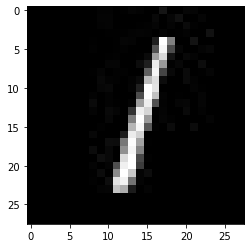

 
Model prediction:  9


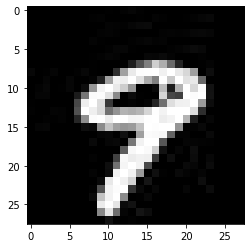

 
Model prediction:  3


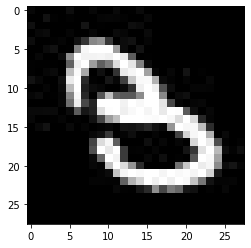

 
Model prediction:  1


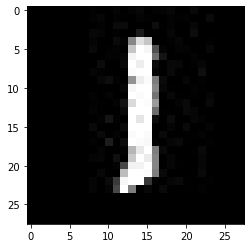

 
Model prediction:  0


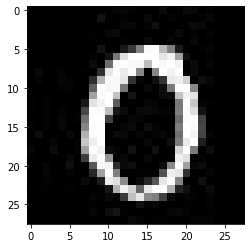

 
Model prediction:  9


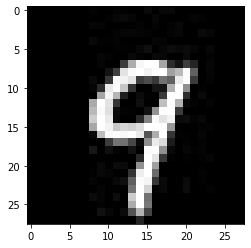

 
Model prediction:  9


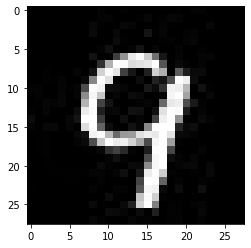

 
Model prediction:  6


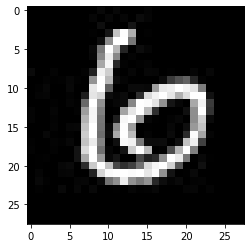

 
Model prediction:  5


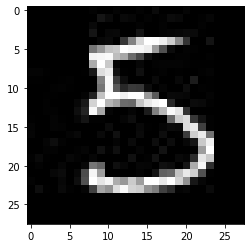

 
Model prediction:  0


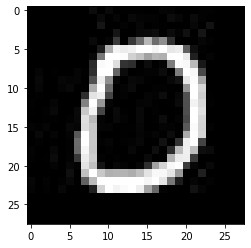

 
Model prediction:  7


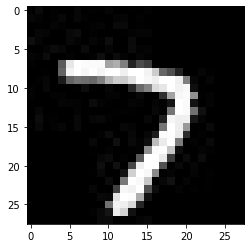

 
Model prediction:  2


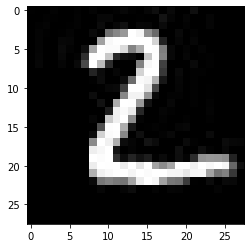

 
Model prediction:  7


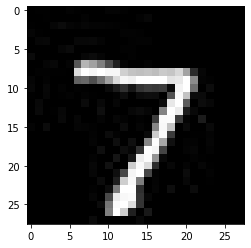

In [20]:
from skimage import io
import glob
import matplotlib.pyplot as plt

file_list = glob.glob("drive/My Drive/public/data/mnist_test_images/*.*")
for img_name in file_list:
  test_img = io.imread(img_name).reshape(28,28)
  test_data = transform(test_img).view(1,1,28,28).to(device)
  fig = plt.figure
  plt.imshow(test_img, cmap='gray')
  with torch.no_grad():
    output=load_model(test_data)
  print('Model prediction: ', output.argmax(dim=1).cpu().numpy()[0])
  plt.show()
  print(' ')

the end! 
----